In [1]:
import pandas as pd
import numpy as np
import bioframe
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
!bedtools sort -i ENCFF519QMV.bed > ENCFF519QMV_sorted.bed

In [3]:
!bedtools closest -a ENCFF519QMV_sorted.bed -b ENCFF519QMV_sorted.bed -d -k 50 > ENCFF519QMV_closest50.bed

In [4]:
H3K27ac = pd.read_table("ENCFF519QMV_closest50.bed", sep="\t", header=None, usecols=[0,1,2,7,20])

In [5]:
H3K27ac.columns = ["chrom", "start", "end", "signal", "distance"]
H3K27ac["H3K27ac"] = H3K27ac["chrom"] + "_" + H3K27ac["start"].astype(str) + "_" + H3K27ac["end"].astype(str)
H3K27ac.head()

,chrom,start,end,signal,distance,H3K27ac
0,chr1,3343819,3343972,5.33433,0,chr1_3343819_3343972
1,chr1,3343819,3343972,5.33433,638794,chr1_3343819_3343972
2,chr1,3343819,3343972,5.33433,806646,chr1_3343819_3343972
3,chr1,3343819,3343972,5.33433,1310177,chr1_3343819_3343972
4,chr1,3343819,3343972,5.33433,1440362,chr1_3343819_3343972


In [6]:
H3K27ac_discard_5kb = H3K27ac.loc[(H3K27ac["distance"] > 0) & (H3K27ac["distance"] <= 2500),"H3K27ac"].unique()

In [7]:
H3K27ac_100kb = H3K27ac[~H3K27ac["H3K27ac"].isin(H3K27ac_discard_5kb)]
H3K27ac_100kb = H3K27ac_100kb.loc[H3K27ac_100kb["distance"] < 100_000,:]
H3K27ac_100kb.head()

,chrom,start,end,signal,distance,H3K27ac
0,chr1,3343819,3343972,5.33433,0,chr1_3343819_3343972
50,chr1,3982765,3983074,5.08152,0,chr1_3982765_3983074
100,chr1,4150617,4150854,12.80341,0,chr1_4150617_4150854
150,chr1,4654148,4654379,4.36797,0,chr1_4654148_4654379
350,chr1,4788439,4788695,7.10066,0,chr1_4788439_4788695


In [8]:
count_100kb_neighbours = H3K27ac_100kb.groupby(["H3K27ac"]).size().reset_index()
count_100kb_neighbours.columns = ["H3K27ac", "neighbours"]
count_100kb_neighbours["neighbours"] = count_100kb_neighbours["neighbours"] - 1
count_100kb_neighbours.head()

,H3K27ac,neighbours
0,chr10_100066526_100066740,1
1,chr10_100164090_100164390,1
2,chr10_100487075_100487255,0
3,chr10_10183188_10183403,0
4,chr10_102512039_102512548,0


In [9]:
H3K27ac_merge = pd.merge(H3K27ac, count_100kb_neighbours, how="inner")
H3K27ac_merge = H3K27ac_merge[["chrom", "start", "end", "signal", "neighbours"]].drop_duplicates()

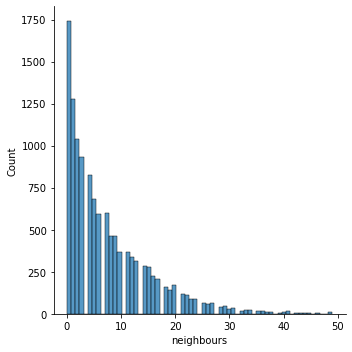

In [10]:
sns.displot(data=H3K27ac_merge, x="neighbours")

In [11]:
H3K27ac_merge.loc[H3K27ac_merge["neighbours"] <= np.quantile(H3K27ac_merge["neighbours"], 0.25), "quartile"] = 1
H3K27ac_merge.loc[H3K27ac_merge["neighbours"] > np.quantile(H3K27ac_merge["neighbours"], 0.25), "quartile"] = 2
H3K27ac_merge.loc[H3K27ac_merge["neighbours"] > np.quantile(H3K27ac_merge["neighbours"], 0.5), "quartile"] = 3
H3K27ac_merge.loc[H3K27ac_merge["neighbours"] > np.quantile(H3K27ac_merge["neighbours"], 0.75), "quartile"] = 4

In [12]:
H3K27ac_merge.loc[H3K27ac_merge["neighbours"] == 0, "neighbour_bin"] = "0"
H3K27ac_merge.loc[H3K27ac_merge["neighbours"] >= 1, "neighbour_bin"] = "1-4"
H3K27ac_merge.loc[H3K27ac_merge["neighbours"] >= 5, "neighbour_bin"] = "5-10"
H3K27ac_merge.loc[H3K27ac_merge["neighbours"] >= 10, "neighbour_bin"] = ">=10"
H3K27ac_merge.head()

,chrom,start,end,signal,neighbours,quartile,neighbour_bin
0,chr1,3343819,3343972,5.33433,0,1.0,0
50,chr1,3982765,3983074,5.08152,0,1.0,0
100,chr1,4150617,4150854,12.80341,0,1.0,0
150,chr1,4654148,4654379,4.36797,0,1.0,0
200,chr1,4788439,4788695,7.10066,14,4.0,>=10


In [13]:
H3K27ac_merge["quartile"] = H3K27ac_merge["quartile"].astype(int)

In [14]:
H3K27ac_merge.to_csv("ENCFF519QMV_100kb_neighbours_binned.bed", sep="\t", index=False)

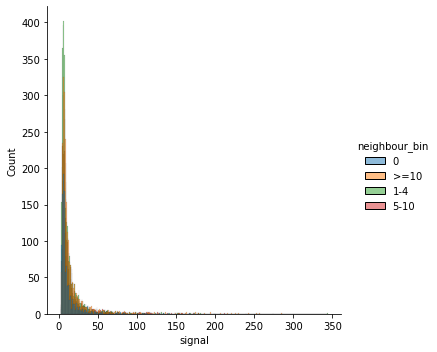

In [15]:
sns.displot(data=H3K27ac_merge, x="signal", hue="neighbour_bin")

Run script neighbours_nullRanges.R before the next step to select peaks which give similar distribution of H3K27ac signal

In [16]:
H3K27ac_matched = pd.read_table("ENCFF519QMV_100kb_neighbours_binned_nullRanges_matched.bed")
H3K27ac_matched = pd.concat([H3K27ac_matched, H3K27ac_merge[H3K27ac_merge["neighbours"] == 0]])
H3K27ac_matched = H3K27ac_matched.sort_values(["chrom", "start"])
H3K27ac_matched.head()

,chrom,start,end,signal,neighbours,neighbour_bin,quartile
0,chr1,3343819,3343972,5.33433,0,0,1
50,chr1,3982765,3983074,5.08152,0,0,1
100,chr1,4150617,4150854,12.80341,0,0,1
150,chr1,4654148,4654379,4.36797,0,0,1
4724,chr1,4788438,4788695,7.10066,14,>=10,4


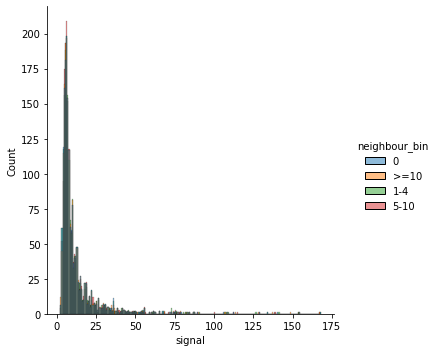

In [17]:
sns.displot(data=H3K27ac_matched, x="signal", hue="neighbour_bin")

In [18]:
H3K27ac_matched.groupby("neighbour_bin").size()

neighbour_bin
0       1741
1-4     1741
5-10    1741
>=10    1741
dtype: int64

In [19]:
H3K27ac_matched.to_csv("ENCFF519QMV_100kb_neighbours_binned_matched.bed", sep="\t", index=False)